In [1]:
#  1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# 2. Load Data
df = pd.read_csv("/content/insurance.csv")

print(df.shape)
print(df.head())
print(df.info())
print(df.describe())


(1338, 7)
   age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


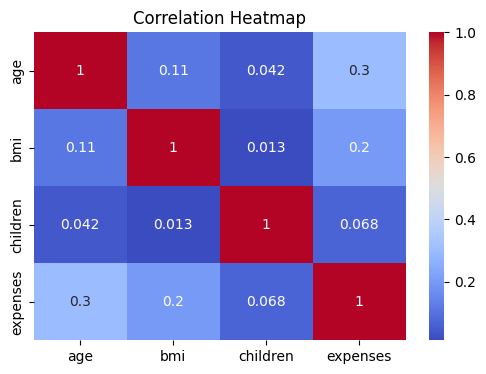

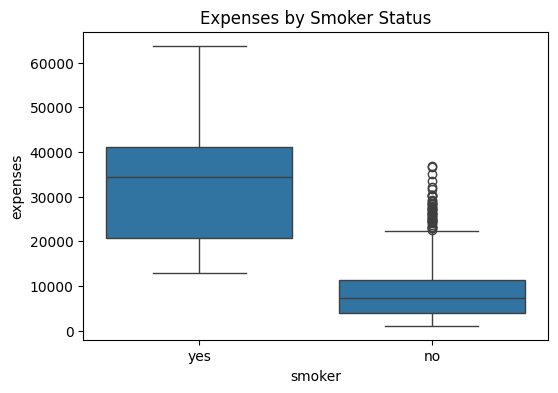

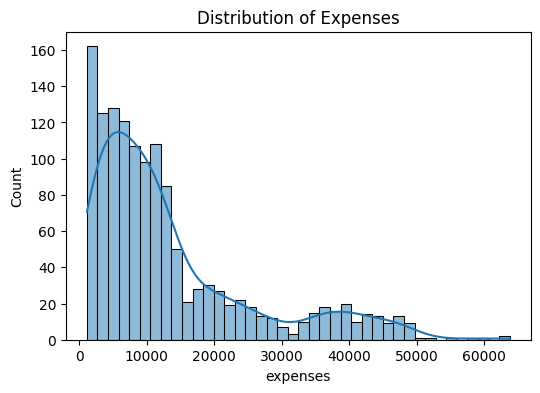

In [4]:
# 3. Exploratory Data Analysis (EDA)

# Missing values
print("Missing values:\n", df.isnull().sum())

# Correlation heatmap (numeric only)
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Boxplot for smoker vs expenses
plt.figure(figsize=(6,4))
sns.boxplot(x="smoker", y="expenses", data=df)
plt.title("Expenses by Smoker Status")
plt.show()

# Distribution of expenses
plt.figure(figsize=(6,4))
sns.histplot(df["expenses"], bins=40, kde=True)
plt.title("Distribution of Expenses")
plt.show()


In [5]:
# 4. Preprocessing

X = df.drop("expenses", axis=1)
y = df["expenses"]

num_features = ["age", "bmi", "children"]
cat_features = ["sex", "smoker", "region"]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first"), cat_features)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
# 5. Linear Regression (Baseline)

lin_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

print("Linear Regression Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("R2:", r2_score(y_test, y_pred_lin))


Linear Regression Performance:
MSE: 33600065.35507784
RMSE: 5796.556335884077
MAE: 4181.561524000794
R2: 0.7835726930039905


In [9]:
# 6. Random Forest Regressor (Advanced)

rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200, random_state=42
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R2:", r2_score(y_test, y_pred_rf))


Random Forest Performance:
MSE: 21064839.789618514
RMSE: 4589.6448435166
MAE: 2569.628842473347
R2: 0.8643155452291245


In [10]:
# 7. Compare Models

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MSE": [
        mean_squared_error(y_test, y_pred_lin),
        mean_squared_error(y_test, y_pred_rf)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_lin)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf))
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lin),
        mean_absolute_error(y_test, y_pred_rf)
    ],
    "R2": [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_rf)
    ]
})

print(results)


               Model           MSE         RMSE          MAE        R2
0  Linear Regression  3.360007e+07  5796.556336  4181.561524  0.783573
1      Random Forest  2.106484e+07  4589.644844  2569.628842  0.864316


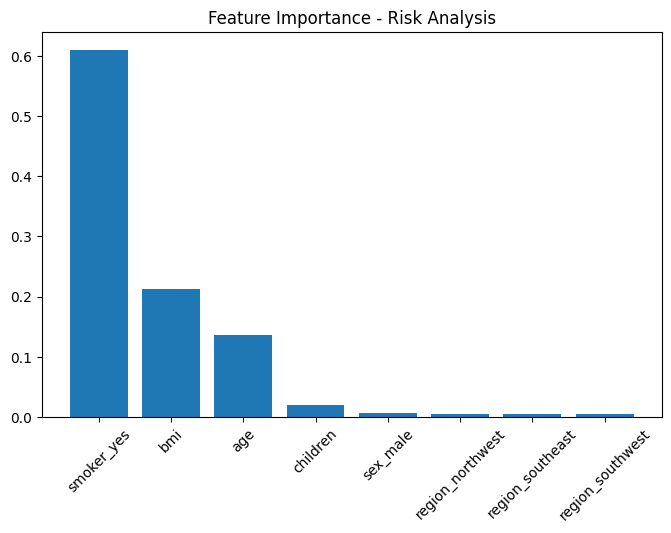

In [11]:
# 8. Feature Importance (Risk Factors)

# Extract feature names
cat_encoder = rf_model.named_steps["preprocessor"].named_transformers_["cat"]
cat_names = cat_encoder.get_feature_names_out(cat_features)
all_features = num_features + list(cat_names)

# Feature importance
importances = rf_model.named_steps["regressor"].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [all_features[i] for i in indices], rotation=45)
plt.title("Feature Importance - Risk Analysis")
plt.show()


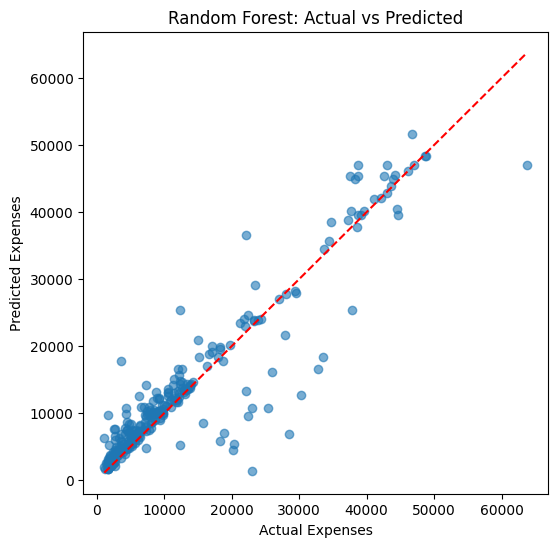

In [12]:
# 9. Visualization: Actual vs Predicted

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Expenses")
plt.ylabel("Predicted Expenses")
plt.title("Random Forest: Actual vs Predicted")
plt.show()
